In [1]:
from sklearn.cluster import KMeans
import sys
sys.path.insert(1, '../permus_util')
sys.path.insert(0, '/Users/ekhine/Desktop/gits/top-k-mallows')
import mallows_kendall as mk
import permutil as pu
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
palette1 = sns.color_palette("tab10", 2)
palette2 = sns.color_palette("husl", 2)

# `STUDENTS` Dataset

This document describes the dataset `STUDENTS`. It includes 348 rankings, each provided by a different student of the course 'Ecomomics and Enterprise' in Tecnun University. Each ranking sorts 4 words in order of similarity to the word `amortization`. The words are: `depreciation`, `expense`, `lifetime`, `payment`. There exists a real ground-true ranking, which is denoted along the experiment as `true_ranking` =[  `depreciation`, `expense`, `lifetime`, `payment` ] = [0,1,2,3].

Each row in the file `students.csv` correspods to one student. The columns `i0` to `i3` give the **ranking** corresponding to the items `depreciation`, `expense`, `lifetime`, `payment`, so the 

There are two cohorts in this dataset:

- sample 1: the experiment is carried out **before** the class, 
- sample 2: the experiment is carried out **after** the class.


The questions that we try to solve are:

- Do the students *learn* in the class? Are the answers after the class closer to the ground-true ranking?
- In general, we have access to the sample but do not have access to the ground-true answer. Can we separete the expert students from the non-expert students with statistics from the sample (with out knowing `true_ranking`?

## References

This work is a real-word experimental evaluation of WP ??? in the project SENDAI (Eklartek program). The theoretical background can be found in \[2].


- \[1]  A Learning Theory of Ranking Aggregation
Anna Korba, Stéphan Clemencon, Eric Sibony. Proceedings of the 20th International Conference on Artificial Intelligence and Statistics, PMLR 54:1001-1010, 2017.
- \[2] Concentric mixtures of Mallows models for top-k rankings: sampling and identifiability. Fabien Collas, Ekhine Irurozki. https://arxiv.org/abs/2010.14260 

## Loading the data
The following lines show how to load the data and plot an histogram of the distances to the `true_ranking`

The first 3 rankings are
[[3 2 0 1]
 [2 3 0 1]
 [0 3 1 2]]


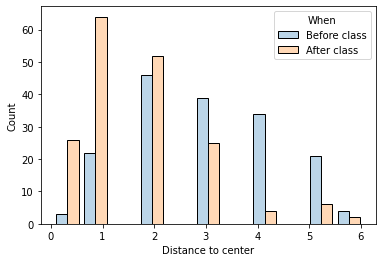

In [2]:
dfstu = pd.read_csv('./students.csv')
rankings = dfstu[['i0', 'i1', 'i2', 'i3']].values
n, true_ranking = 4,[0,1,2,3]
ax = sns.histplot(data=dfstu, x="Distance to center", hue="When", multiple="dodge", 
             shrink=.8, alpha=0.3,palette=palette1)
print("The first 3 rankings are")
print(rankings[:3,:])

# Improvement after class

The first question is to analyze whether the students' answers improved by taking the class. The most direct approach is to measure 

- the distance between the average ranking of the student **before** the class and the `true_ranking` and
- the distance between the average ranking of the student **after** the class and the `true_ranking`.

The average ranking before the class was further than the average distance after the class. Therefore, we can conclude that the students did learn in the class. 


In [3]:
r_bef = dfstu[dfstu.When=='Before class'][['i0', 'i1', 'i2', 'i3']].values
r_aft = dfstu[dfstu.When=='After class'][['i0', 'i1', 'i2', 'i3']].values
median_bef = np.argsort(np.argsort(r_bef.sum(axis=0)))
median_aft = np.argsort(np.argsort(r_aft.sum(axis=0)))
print("The distance of the average ranking before the class is", mk.distance(true_ranking,median_bef))
print("The distance of the average ranking before the class is", mk.distance(true_ranking,median_aft))
print("Did the students learn?", mk.distance(true_ranking,median_bef) > mk.distance(true_ranking,median_aft))


The distance of the average ranking before the class is 2
The distance of the average ranking before the class is 1
Did the students learn? True


# Kendall's-$\tau$ depth

We know that if the ranking provided by student $a$ is closer to the `true_ranking` than the ranking provided by student $b$ then student $a$ is *more expert/better* than student $b$. However, in general, we will not have access to `true_ranking` (nor to the distance to the `true_ranking`). Is it still possible to measure how good a student's ranking is?

In the follwing experiment, we consider two different measures for each ranking (i.e., student) in the sample:

- Distance to the `true_ranking`: given that the `true_ranking` is known, we can measure the quality of each student as the (Kendall's-$\tau$) distance between the ranking provided by the student and the `true_ranking`.
- Depth: for each ranking $\sigma$, it's defined as $n(n-1)/2$ minus the sum of the (Kendall's-$\tau$) distances between $\sigma$ and the rest of the rankings in the sample.

Under certain conditions both measures are correlated, \[1,2]. In this experiment, we plot each ranking as a dot in coordinates (x,y) where *x* is the 'Depth' and *y* the 'Distance to the center'. Moreover, we fit a linear regression model between the two variables. We see that for this real data both measures are also correlated, which suggests that we can estimate the distance to the ground-true ranking with the distance to the sample. 




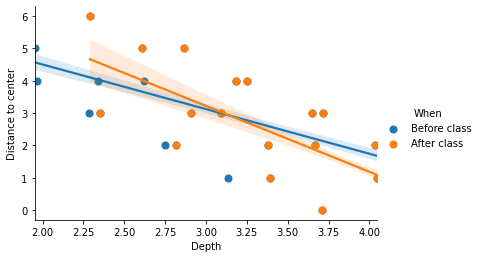

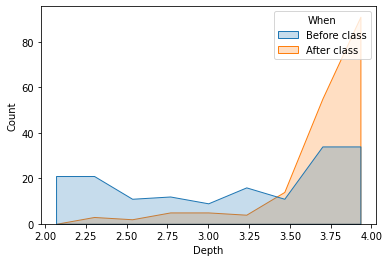

In [4]:
d_sample,depths, res = [], [], []
P = pu.sample_to_marg_rel(rankings)
for perm in rankings:
    depths.append( n*(n-1)/2 -  pu.dist_to_sample(perm,P) )
    d_sample.append(   pu.dist_to_sample(perm,P) )
dfstu["Depth"] = depths
dfstu["Distance to sample"] = d_sample
dfstu.head()
col_x = "Depth"#  "Distance to sample" # "Depth"
sns.lmplot(x=col_x, y="Distance to center", data=dfstu,hue='When',
           x_estimator=np.mean,palette=palette1, height=3.5, aspect=1.5)
# plt.savefig('delta_dist.jpg')
plt.show()
g = sns.histplot(data=dfstu, x=col_x, hue="When", 
                 element="poly",palette=palette1, bins=9)
# plt.savefig('delta_hist.jpg')

## Off-the-shelf clustering algorithms to segment the mixture
In the following, we only consider the group **after-class**. We see in the previous plot that this is a hetereogeneos group, where there are experts and non-experts. In this section, we separete both groups based on the 'Distance to sample'. 

When the students inside one group are *different enought*, a clustering algorithm can separate the expert from the non-expert students in the group (a bound for this difference is given in  \[2]). In the next figure, we show that a clustering algorithms (an off-the-shelf KMeans) can separare the good (red) and the bad (green) students. The clustering of the group is visualized in the following figure. 

> **We conclude by noting that we have separated the experts from the non-expert student using sample statistics (i.e., using the 'Distance to sample' and without knowing the center $s0$). This result is consistent with the theoretical findings in \[2].**



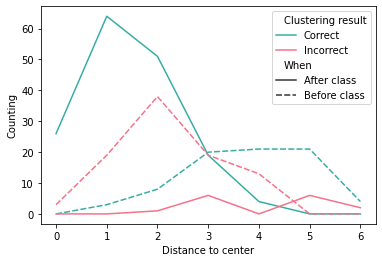

In [5]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(dfstu['Depth'].values.reshape(-1,1))
dfstu['Clustering result'] = ['After class' if i==0 else 'Before class' for i in kmeans.labels_]
dfstu['Clustering result'] = (dfstu['Clustering result'] == dfstu['When'])
dfstu['Clustering result'] = ['Correct' if i else 'Incorrect' for i in  dfstu['Clustering result'].values]


all_d = list(range(7)) #code to fill voids
all_w = ['Before class', 'After class']
all_c = ['Correct', 'Incorrect']
combined = [all_d, all_w, all_c]
df1 = pd.DataFrame(columns = ['Distance to center', 'When', 'Clustering result'], data=list(itertools.product(*combined)))

a = dfstu.groupby(['Distance to center', 'When','Clustering result']).size()
a = a.reset_index(name='Counting')
a = pd.merge(a,df1,how='outer').fillna(0)
ax = sns.lineplot(data=a,x='Distance to center', y='Counting', hue='Clustering result', 
                  style='When',palette=palette2[::-1])
# plt.savefig('clustering_performance.jpg')

In [7]:

kmeans.labels_.astype(bool)
rankings = dfstu[~kmeans.labels_.astype(bool)][['i0', 'i1', 'i2', 'i3']].values
med = np.argsort(np.argsort(rankings.sum(axis=0)))
print("The distance of the average ranking of the estimated as expert is",
      mk.distance(true_ranking,med),len(rankings))
rankings = dfstu[kmeans.labels_.astype(bool)][['i0', 'i1', 'i2', 'i3']].values
med = np.argsort(np.argsort(rankings.sum(axis=0)))
print("The distance of the average ranking of the estimated as non-expert is",
      mk.distance(true_ranking,med),len(rankings))



The distance of the average ranking of the estimated as expert is 2 256
The distance of the average ranking of the estimated as non-expert is 5 92


In [26]:
cor = a[(a['When']=='Before class')&(a['Clustering result']=='Correct')].sort_values('Distance to center').Counting
inc = a[(a['When']=='Before class')&(a['Clustering result']=='Incorrect')].sort_values('Distance to center').Counting
(cor.values - inc.values)

array([ -3., -16., -30.,   1.,   8.,  21.,   4.])

In [17]:
a[(a['When']=='Before class')&(a['Clustering result']=='Incorrect')].sort_values('Distance to center')

,Distance to center,When,Clustering result,Counting
1,0,Before class,Incorrect,3.0
4,1,Before class,Incorrect,19.0
8,2,Before class,Incorrect,38.0
12,3,Before class,Incorrect,19.0
15,4,Before class,Incorrect,13.0
24,5,Before class,Incorrect,0.0
26,6,Before class,Incorrect,0.0
